In [1]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, default_data_collator, \
    DataCollatorForLanguageModeling
from datasets import load_dataset
from arguments import DataTrainingArguments, ModelArguments, TrainingArguments
from collections import defaultdict
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import color_idx, room_idx

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base', legacy=True)

# Initialize the data arguments
data_args = DataTrainingArguments(
    datasets='floorplan',
    data_dir=None,
    train_split='train',
    max_seq_length=512,
    max_output_seq_length=512,
    max_seq_length_eval=512,
    max_output_seq_length_eval=512,
    exp='full',
    boundary_in_where='Encoder'
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [39]:
model = T5ForConditionalGeneration.from_pretrained(
    'experiments/floorplan-t5-base-full-ep20-len512-b4-train-original-baseline/episode0')

In [40]:
# Example usage
input_sentence = "Balcony 1 is about 8 foot X 2 foot.  This is located right off of the kitchen. Balcony 2 is about 10 foot X 3 foot.  This is facing north of the house. The bathroom is about 8 foot X 6 foot.  It is located between the living room and the kitchen. Common room 1 is about 10 foot X 12 foot.  The common rooms are located diagonal from each other. Common room 2 is about 10 foot X 10 foot.  The common rooms are located diagonal from each other. The kitchen is a 10 foot X 10 foot room.  It looks like it is opened up to the living room. The living room is located on the east side of the house.  It is shaped like a \"T\" and it's the biggest room.  It is approximately 14 feet X 32 feet.  Each room that you come out of you will enter the living room. The master is about 10 feet X 15 feet.  It is located far west of the house.It is a rectangle shape."
input_ids = tokenizer(input_sentence, return_tensors="pt").input_ids

# Generate output
output_ids = model.generate(input_ids, max_new_tokens=512)
output_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Output sentence:", output_sentence)

Output sentence: [ master room | x coordinate = 143 | y coordinate = 173 | height = 56 | width = 41 ] [ kitchen | x coordinate = 166 | y coordinate = 122 | height = 49 | width = 55 ] [ common room | x coordinate = 89 | y coordinate = 173 | height = 46 | width = 41 ] [ living room | x coordinate = 102 | y coordinate = 106 | height = 73 | width = 87 ] [ bathroom | x coordinate = 156 | y coordinate = 135 | height = 29 | width = 29 ]


In [41]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [42]:
from datasets import load_dataset

test_dataset = load_dataset('floorplan', data_args, split='finetune',
                            max_input_length=data_args.max_seq_length,
                            max_output_length=data_args.max_output_seq_length,
                            tokenizer=tokenizer, seed=1)

In [43]:
# test_dataset.get_example(0)

In [44]:
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=default_data_collator)


def generate_output_sentences():
    for i, inputs in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
        predictions = model.generate(
            inputs['input_ids'].to(device),
            max_length=data_args.max_output_seq_length_eval,
            num_beams=5,
            decoder_input_ids=inputs['decoder_boundary_ids']
        )
        for j, (input_ids, label_ids, prediction) in enumerate(
                zip(inputs['input_ids'], inputs['labels'], predictions)):
            current_id = i * batch_size + j
            example = test_dataset.get_example(current_id)
            output_sentence = tokenizer.decode(prediction, skip_special_tokens=True, clean_up_tokenization_spaces=False)
            yield example, output_sentence, None

In [45]:
' '.join(test_dataset.get_example(100).tokens)

"Balcony is located at South side of House . Balcony is located at Rear side of Living Room and Master Room . The Approximate size of Balcony is 12' x 4' . Bathroom 1 is located at West side of House . Bathroom 1 is located Left to Master Room and Rear side of Common Room 2 . The Approximate size of Bathroom 1 is 8' x 6' . Bathroom 2 is located at North West Side of House . Bathroom 2 is located between Kitchen and Common Room 2 and in front of Living Room . The Approximate size of Bathroom 2 is 6' x 8' . Common Room 1 is located at North East Corner of House . Common Room 1 is located Right to Living Room and Kitchen . The Approximate size of Common Room 1 is 10' x 14' . Common Room 2 is located at North West Corner of House . Common Room 2 is located Left to Bathroom 2 and Living Room and in front of Bathroom 1 and Master Room . The Approximate size of Common Room 2 is 8' x 14' . Kitchen is located at North East side of House . Kitchen is located between Common Room 1 and Bathroom 2 

In [46]:
def generate_output_sentence(idx):
    example = test_dataset.get_example(idx)
    input_sentence = ' '.join(example.tokens)
    input_ids = tokenizer(input_sentence, return_tensors="pt").input_ids
    output_ids = model.generate(input_ids, max_new_tokens=512)
    output_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return example, output_sentence, None

In [47]:
def generate_one_output_sentence():
    # Get the first batch from the test_data_loader
    inputs = next(iter(test_data_loader))

    # Generate prediction
    predictions = model.generate(
        inputs['input_ids'].to(device),
        max_length=data_args.max_output_seq_length_eval,
        num_beams=5,
        decoder_input_ids=inputs['decoder_boundary_ids']
    )

    # Get the first prediction
    prediction = predictions[0]

    # Get the first example
    example = inputs

    # Decode the prediction to get the output sentence
    output_sentence = tokenizer.decode(prediction, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return example, output_sentence, None

In [62]:
import random

random_idx = random.choice(range(len(test_dataset)))
example, output_sentence, predicted_index = generate_output_sentence(random_idx)
print(test_dataset.input_format.format_input(example, multitask=False))
print("Output sentence:", output_sentence)

The balcony is 4 feet long and 14 feet wide . It borders with the common room at the northern line . The bathroom is about middle ways but on the west side and the kitchen touches its northern line . It would be about 4 feet long and 6 feet wide . The common room is about 20 feet wide and 14 feet long and anchors in the southern part of the house and the balcony sharing it's southern border . The kitchen is roughly 8 feet long and 18 feet wide and nestles at the point where the wall dog legs left or west . It sits with the living room on it's northern border . The living room takes up all of the northern wall of the home and the common room meets with it's handle or extention to the south . It is 20 feet long and about 30 feet wide . The master room meets the common room on the east side and the master room rests in the southeastern corner of the house . It is about 18 feet long and 16 feet wide .
Output sentence: [ master room | x coordinate = 143 | y coordinate = 173 | height = 56 | 

In [63]:
gt_boxes = defaultdict(list)
for room in example.rooms:
    gt_x, gt_y, gt_h, gt_w = room.x, room.y, room.h, room.w
    gt_box = [
        [int(gt_x - gt_h / 2), int(gt_y - gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y - gt_w / 2)],
        [int(gt_x - gt_h / 2), int(gt_y + gt_w / 2)], [int(gt_x + gt_h / 2), int(gt_y + gt_w / 2)]
    ]
    gt_boxes[room.type] = gt_box

In [64]:
res = test_dataset.output_format.run_inference(example, output_sentence[51:], predicted_index)
predicted_rooms_by_name, predicted_rooms, raw_predicted_relations, wrong_reconstruction, format_error, label_error = res

In [65]:
predicted_attribute = defaultdict()
for attribute_tuple in raw_predicted_relations:
    attribute_type, value, room_tuple, room_type = attribute_tuple
    if room_type not in predicted_attribute:
        predicted_attribute[room_type] = defaultdict()
    try:
        value = int(value)
    except:
        value = 128
    predicted_attribute[room_type][attribute_type] = value

In [66]:
# TODO: examine the predicted_attribute patterns
correct_attributes = ['x coordinate', 'y coordinate', 'height', 'width']
wrong_room = []
for room_type in predicted_attribute:
    if set(list(predicted_attribute[room_type].keys())) != set(correct_attributes):
        print('wrong output format:')
        print(predicted_attribute[room_type])
        wrong_room.append(room_type)
for wrong_r in wrong_room:
    predicted_attribute.pop(wrong_r)

In [67]:
all_gt_rooms = [room.type for room in example.rooms]
predicted_boxes = defaultdict()
for room in predicted_attribute:
    predicted_boxes[room] = [
        [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] - predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] - predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)],
        [int(predicted_attribute[room]['x coordinate'] + predicted_attribute[room]['height'] / 2),
         int(predicted_attribute[room]['y coordinate'] + predicted_attribute[room]['width'] / 2)]
    ]


In [68]:
for room in gt_boxes:
    y_min = gt_boxes[room][0][1]
    x_min = gt_boxes[room][0][0]
    y_max = gt_boxes[room][3][1]
    x_max = gt_boxes[room][3][0]
    gt_boxes[room] = (y_min, x_min, y_max, x_max)

In [69]:
for room in predicted_boxes:
    y_min = predicted_boxes[room][0][1]
    x_min = predicted_boxes[room][0][0]
    y_max = predicted_boxes[room][3][1]
    x_max = predicted_boxes[room][3][0]
    predicted_boxes[room] = (y_min, x_min, y_max, x_max)

In [70]:
# render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes, output_dir)

In [71]:
def render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes):
    image_height = 256
    image_width = 256
    number_of_color_channels = 3
    background_color = (255, 255, 255)
    gt_image = np.full((image_height, image_width, number_of_color_channels), background_color, dtype=np.uint8)
    predicted_image = np.full((image_height, image_width, number_of_color_channels), background_color, dtype=np.uint8)
    boundary_color = [0, 0, 0]

    left_boundary = int(example.boundary_tokens[1])

    living = defaultdict()
    common = defaultdict()
    master = defaultdict()
    balcony = defaultdict()
    bathroom = defaultdict()
    kitchen = defaultdict()
    storage = defaultdict()
    dining = defaultdict()
    for room in predicted_boxes:
        if room.startswith('living'):
            living[room] = predicted_boxes[room]
        elif room.startswith('common'):
            common[room] = predicted_boxes[room]
        elif room.startswith('master'):
            master[room] = predicted_boxes[room]
        elif room.startswith('balcony'):
            balcony[room] = predicted_boxes[room]
        elif room.startswith('bathroom'):
            bathroom[room] = predicted_boxes[room]
        elif room.startswith('kitchen'):
            kitchen[room] = predicted_boxes[room]
        elif room.startswith('storage'):
            storage[room] = predicted_boxes[room]
        elif room.startswith('dining'):
            dining[room] = predicted_boxes[room]
    room_type_list = [living, common, master, balcony, bathroom, kitchen, storage, dining]
    for room_type in room_type_list:
        for room in room_type:
            left_top_pr = (room_type[room][0], room_type[room][1])
            right_bt_pr = (room_type[room][2], room_type[room][3])

            color = color_idx[room_idx[room]]
            # draw room on predicted image
            cv2.rectangle(predicted_image, left_top_pr, right_bt_pr, color, -1)

    # Draw the directions
    # height, width, _ = predicted_image.shape
    #
    # cv2.putText(predicted_image, "South", (int(width/2), height-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    # cv2.putText(predicted_image, "North", (int(width/2), 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    # cv2.putText(predicted_image, "West", (10, int(height/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    # cv2.putText(predicted_image, "East", (width-50, int(height/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

    # for boundary_pixel in example.boundary:
    #     predicted_image[boundary_pixel[0], boundary_pixel[1]] = boundary_color

    return predicted_image

In [72]:
pre_image = render_image_(example, gt_boxes, all_gt_rooms, gt_boxes)

In [73]:
import matplotlib.patches as mpatches


def render_image_with_legend(example, predicted_boxes, all_gt_rooms, gt_boxes):
    # Render the image as before
    image = render_image_(example, predicted_boxes, all_gt_rooms, gt_boxes)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Add direction labels for the entire floor plan
    plt.text(0.5, 0.02, "South", fontsize=10, ha='center', va='bottom', color='red', transform=plt.gca().transAxes)
    plt.text(0.5, 0.98, "North", fontsize=10, ha='center', va='top', color='red', transform=plt.gca().transAxes)
    plt.text(0.02, 0.5, "West", fontsize=10, ha='left', va='center', color='red', transform=plt.gca().transAxes)
    plt.text(0.98, 0.5, "East", fontsize=10, ha='right', va='center', color='red', transform=plt.gca().transAxes)

    # Create a legend
    patches = [mpatches.Patch(color=np.array(color_idx[room_idx[room]]) / 255., label=room) for room in all_gt_rooms]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Show the plot
    plt.show()

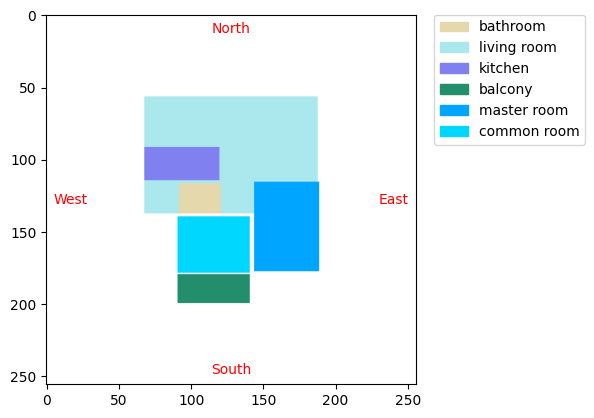

In [74]:
render_image_with_legend(example, gt_boxes, all_gt_rooms, gt_boxes)

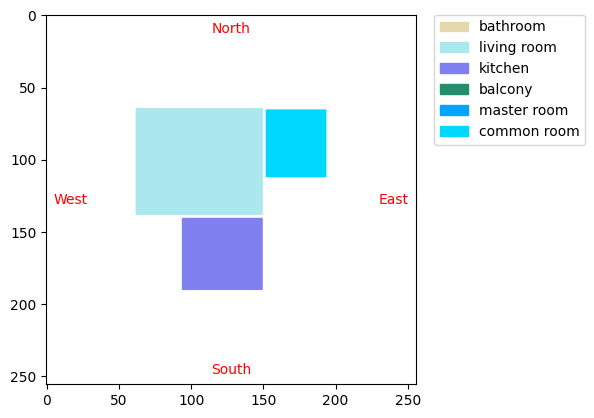

In [75]:
render_image_with_legend(example, predicted_boxes, all_gt_rooms, gt_boxes)